In [2]:
import numpy as np
from testCases_v3 import *
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [9]:
#Dataset
from dnn_utils_v2 import *

train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print(train_x.shape)
print(train_y.shape)

(12288, 209)
(1, 209)


y = 0. It's a non-cat picture.


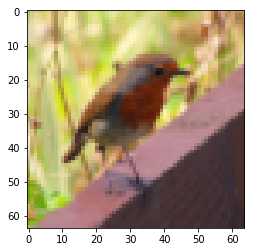

In [10]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [3]:
σ = lambda Z: (1/(1 + np.exp(-Z)))
dσ = lambda Z: (σ(Z) * (1 - σ(Z)))
Relu = lambda Z: (np.maximum(0,Z))
dRelu = lambda Z: ((Z > 0) * 1)
#Relu's derivative: 0 if Z[i] <= 0 and 1 if Z[i] > 0

In [4]:
def forward_propagation(X, Weights):
    L = len(Weights)
    caches = []

    A = X
    for l in range(L-1):
        W,b = Weights[l]

        A_prev = A

        Z = np.dot(W, A_prev) + b
        A = Relu(Z)

        caches.append((A_prev, W, Z))
        
    A_prev = A
    #Last layer
    W,b = Weights[L-1]

    Z = np.dot(W, A_prev) + b
    y_hat = σ(Z)

    caches.append((A_prev, W, Z))

    return y_hat, caches

In [5]:
def backpropagation(y_hat, y, caches):
    L = len(caches)
    m = y_hat.shape[1]
    grads = []

    A_prev, W, Z = caches[L-1]
    #Last layer
    dy_hat = ( (1-y)/(1-y_hat) ) - ( y/y_hat )
    dZ = dy_hat * dσ(Z)
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA = np.dot(W.T, dZ)

    grads.append((dW,db))

    for l in reversed(range(L-1)):
        A_prev, W, Z = caches[l]    
        dZ = dA * dRelu(Z)
        dW = 1/m * np.dot(dZ, A_prev.T)
        db = 1/m * np.sum(dZ, axis=1, keepdims=True)
        dA = np.dot(W.T, dZ)

        grads.append((dW,db))

    grads = list(reversed(grads))
    return grads

In [6]:
def initialize(layer_dimensions):
    #layer_dimensions[0] is the input layer size
    np.random.seed(1)
    L = len(layer_dimensions)
    Weigths = []

    for l in range(1,L):
        W = np.random.randn(layer_dimensions[l],layer_dimensions[l-1]) / np.sqrt(layer_dimensions[l-1])
        b = np.zeros((layer_dimensions[l],1))

        Weigths.append((W,b))

    return Weigths

In [7]:
cross_entropy_loss = lambda y_hat, y: np.squeeze(( 1/y.shape[1] * (-np.dot(y,np.log(y_hat).T) - np.dot(1-y, np.log(1-y_hat).T)) ) )

In [8]:
def update(Weights, α, grads):
    L = len(Weights)

    for l in range(L):
        W,b = Weights[l]

        dW, db = grads[l]
        Weights[l] = W-α*dW, b-α*db

    return Weights

In [15]:
#Final L-layer model
def model(X,y, layer_dimensions, α, iters, print_cost = False):
    np.random.seed(1)
    costs = []
    m = X.shape[1]

    Weigts = initialize(layer_dimensions)

    for i in range(iters):
        
        y_hat, caches = forward_propagation(X, Weigts)

        cost = cross_entropy_loss(y_hat, y)
        
        grads = backpropagation(y_hat, y, caches)
        
        Weigts = update(Weigts, α, grads)  

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    costs = np.squeeze(costs)
    #plt.plot(np.squeeze(costs))
    #plt.ylabel('cost')
    #plt.xlabel('iterations (per tens)')
    #plt.title("Learning rate =" + str(α))
    #plt.show()
    return Weigts, costs

Cost after iteration 0: 0.695046
Cost after iteration 100: 0.589260
Cost after iteration 200: 0.523261
Cost after iteration 300: 0.449769
Cost after iteration 400: 0.420900
Cost after iteration 500: 0.372464
Cost after iteration 600: 0.347421
Cost after iteration 700: 0.317192
Cost after iteration 800: 0.266438
Cost after iteration 900: 0.219914
Cost after iteration 1000: 0.143579
Cost after iteration 1100: 0.453092
Cost after iteration 1200: 0.094994
Cost after iteration 1300: 0.080141
Cost after iteration 1400: 0.069402
Cost after iteration 1500: 0.060217
Cost after iteration 1600: 0.053274
Cost after iteration 1700: 0.047629
Cost after iteration 1800: 0.042976
Cost after iteration 1900: 0.039036
Cost after iteration 2000: 0.035683
Cost after iteration 2100: 0.032915
Cost after iteration 2200: 0.030472
Cost after iteration 2300: 0.028388
Cost after iteration 2400: 0.026615


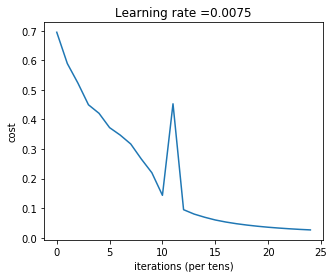

In [102]:
layer_dimensions = [12288, 7, 1]
α = 0.0075
iters = 2500
Weights, costs = model(train_x, train_y, layer_dimensions, α, iters, print_cost=True)

plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(α))
plt.show()

In [104]:
def check(X, y, Weigths):
    preds, _ = forward_propagation(X, Weigths)
    preds = (preds > 0.5)*1

    pos = 0
    m = preds.shape[1]
    for i in range(m):
        if y[0][i] == preds[0][i]:
           pos += 1

    print(str(pos/m)+'% Accuracy')

In [105]:
check(test_x, test_y, Weights)

0.74% Accuracy


In [106]:
def predict(test, Weights):

    #plot image
    plt.imshow(test)
    plt.plot()
    #flatten image
    test =  np.reshape(test.flatten(), (12288,1))

    pred, _ = forward_propagation(test, Weights)
    if pred == 1:
        print('It is a cat')
    else:
        print('It is not a cat')

In [107]:
import cv2

#import image
prueba = cv2.resize(cv2.imread('test.jpg'), (64,64), interpolation = cv2.INTER_AREA)
prueba = cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB)

It is a cat


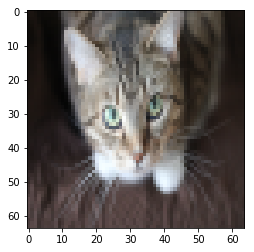

In [108]:
predict(prueba, Weights)